# Test constants

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import healpy as hp

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from modules.utils import train_model_2steps, init_device
from modules.data import WeatherBenchDatasetXarrayHealpix
from modules.healpix_models import UNetSphericalHealpix
from modules.test import create_iterative_predictions_healpix
from modules.test import compute_rmse_healpix
from modules.plotting import plot_rmses

datadir = "../data/healpix/"
input_dir = datadir + "5.625deg/"
model_save_path = datadir + "models/"
pred_save_path = datadir + "predictions/"

train_years = ('1979', '2012')
val_years = ('2013', '2016')
test_years = ('2017', '2018')

nodes = 12*16*16
max_lead_time = 5*24
lead_time = 6
out_features = 2
nb_timesteps = 2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
gpu = [0]
num_workers = 10
pin_memory = True
batch_size = 95

nb_epochs = 10
learning_rate = 8e-3

obs = xr.open_mfdataset(pred_save_path + 'observations2.nc', combine='by_coords')
#rmses_weyn = xr.open_dataset(datadir + 'metrics/rmses_weyn.nc')

In [4]:
obs

<xarray.Dataset>
Dimensions:    (lead_time: 20, node: 3072, time: 17388)
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
  * time       (time) datetime64[ns] 2017-01-01T06:00:00 ... 2018-12-26T17:00:00
  * node       (node) int64 0 1 2 3 4 5 6 ... 3065 3066 3067 3068 3069 3070 3071
    lat        (node) float64 dask.array<chunksize=(3072,), meta=np.ndarray>
    lon        (node) float64 dask.array<chunksize=(3072,), meta=np.ndarray>
Data variables:
    z          (lead_time, time, node) float64 dask.array<chunksize=(20, 17388, 3072), meta=np.ndarray>
    t          (lead_time, time, node) float64 dask.array<chunksize=(20, 17388, 3072), meta=np.ndarray>

**Comments:**

Normalization performed after defining ```n_samples```; otherwise it converts the data into dataset and since it's not an array anymore it doesn't have a shape

In [4]:
from modules.data import WeatherBenchDatasetIterative
class WeatherBenchDatasetXarrayHealpix(Dataset):
    """ Dataset used for graph models (1D), where data is loaded from an xarray Dataset
    
    Parameters
    ----------
    ds : xarray Dataset
        Dataset containing the input data
    lead_time : int
        Prediction interval (in hours)
    out_features : int
        Number of output features
    years : tuple(str)
        Years used to split the data
    nodes : float
        Number of nodes each sample has
    max_lead_time : int
        Maximum lead time (in case of iterative predictions) in hours
    load : bool
        If true, load dataset to RAM
    mean : np.ndarray of shape 2
        Mean to use for data normalization. If None, mean is computed from data
    std : np.ndarray of shape 2
        std to use for data normalization. If None, mean is computed from data
    """
    
    def __init__(self, ds, out_features, lead_time, years, nodes, nb_timesteps, max_lead_time=None, 
                 load=True, mean=None, std=None):
        
        self.lead_time = lead_time
        self.years = years
        self.nodes = nodes
        self.out_features = out_features
        self.max_lead_time = max_lead_time
        self.nb_timesteps = nb_timesteps
        
        self.data = ds.to_array(dim='level', name='Dataset').transpose('time', 'node', 'level')
        self.in_features = self.data.shape[-1]
        
        self.mean = self.data.mean(('time', 'node')).compute() if mean is None else mean
        self.std = self.data.std(('time', 'node')).compute() if std is None else std
        
        
        if max_lead_time is None:
            self.n_samples = self.data.isel(time=slice(0, -self.nb_timesteps*lead_time)).shape[0]
        else:
            self.n_samples = self.data.isel(time=slice(0, -self.nb_timesteps*lead_time)).shape[0] - max_lead_time
        self.idxs = np.arange(self.n_samples)
        
        # Normalize
        self.data = (self.data - self.mean) / self.std
        
        if load: 
            print('Loading data into RAM')
            self.data.load()
        
    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        idxs = self.idxs[idx]
        
        X = (torch.Tensor(self.data.isel(time=idxs).values),
             torch.Tensor(self.data.isel(time=idxs + self.lead_time).values[:, self.out_features:]))
        
        y = (torch.Tensor(self.data.isel(time=idxs + self.lead_time).values[:, :self.out_features]), 
             torch.Tensor(self.data.isel(time=idxs + 2*self.lead_time).values[:, :self.out_features]))

        return X, y


def create_iterative_predictions_healpix(model, device, dg):
    train_std =  dg.dataset.std.values[:2]
    train_mean = dg.dataset.mean.values[:2]
    
    delta_t = dg.dataset.lead_time
    max_lead_time = dg.dataset.max_lead_time
    initial_lead_time = delta_t
    nodes = dg.dataset.nodes
    nside = int(np.sqrt(nodes/12))
    n_samples = dg.dataset.n_samples
    in_feat = dg.dataset.in_features
    out_feat = dg.dataset.out_features
    
    # Lead times
    lead_times = np.arange(delta_t, max_lead_time + delta_t, delta_t)
    
    # Lat lon coordinates
    out_lon, out_lat = hp.pix2ang(nside, np.arange(nodes), lonlat=True)
    
    # Actual times
    start = np.datetime64(dg.dataset.years[0], 'h') + np.timedelta64(initial_lead_time, 'h')
    stop = start + np.timedelta64(dg.dataset.n_samples, 'h')
    times = np.arange(start, stop)
    
    # Variables
    var_dict_out = {var: None for var in ['z', 't']}
    
    # Radiation
    constants = np.array(dg.dataset.data.isel(level=slice(out_feat, None)).values)
    
    dataloader = dg
    predictions = []
    model.eval()
    for lead in lead_times:
        outputs = []
        state = []
        states = np.empty((n_samples, nodes, in_feat))
        
        time1 = time.time()

        for i, (sample, _) in enumerate(dataloader):
            inputs = sample[0].to(device)
            output = model(inputs)

            outputs.append(output.detach().cpu().clone().numpy()[:, :, :out_feat])
            state.append(output.detach().cpu().clone().numpy())
            
        preds = np.concatenate(outputs)
        states[:, :, :out_feat] = np.concatenate(state)
        states[:, :, out_feat:] = constants[lead:n_samples+lead, :]

        predictions.append(preds * train_std + train_mean)

        new_set = WeatherBenchDatasetIterative(states)
        dataloader = DataLoader(new_set, batch_size=batch_size, shuffle=False, num_workers=10)
        
        time2 = time.time()
        
    predictions = np.array(predictions)
    
    das = [];
    lev_idx = 0
    for var in ['z', 't']:       
        das.append(xr.DataArray(
            predictions[:, :, :, lev_idx],
            dims=['lead_time', 'time', 'node'],
            coords={'lead_time': lead_times, 'time': times, 'node': np.arange(nodes)},
            name=var
        ))
        lev_idx += 1
            
    prediction_ds = xr.merge(das)
    prediction_ds = prediction_ds.assign_coords({'lat': out_lat, 'lon': out_lon})
    return prediction_ds

In [5]:
z500 = xr.open_mfdataset(f'{input_dir}geopotential_500/*.nc', combine='by_coords').rename({'z':'z500'})
t850 = xr.open_mfdataset(f'{input_dir}temperature_850/*.nc', combine='by_coords').rename({'t':'t850'})
rad = xr.open_mfdataset(f'{input_dir}toa_incident_solar_radiation/*.nc', combine='by_coords')

z500 = z500.isel(time=slice(7, None))
t850 = t850.isel(time=slice(7, None))

constants = xr.open_dataset(f'{input_dir}constants/constants_5.625deg.nc').rename({'orography' :'orog'})
constants = constants.assign(cos_lon=lambda x: np.cos(np.deg2rad(x.lon)))
constants = constants.assign(sin_lon=lambda x: np.sin(np.deg2rad(x.lon)))

temp = xr.DataArray(np.zeros(z500.dims['time']), coords=[('time', z500.time.values)])
constants, _ = xr.broadcast(constants, temp)

orog = constants['orog']
lsm = constants['lsm']
lats = constants['lat2d']
slt = constants['slt']
cos_lon = constants['cos_lon']
sin_lon = constants['sin_lon']

In [6]:
input_dir = '../data/healpix/5.625deg/'

In [7]:
z = xr.open_mfdataset(f'{input_dir}geopotential_500/*.nc', combine='by_coords')['z']\
.assign_coords(level=1)

t = xr.open_mfdataset(f'{input_dir}temperature_850/*.nc', combine='by_coords')['t']\
.assign_coords(level=1)

predictors = xr.concat([z, t], 'level')

In [8]:
constants.lon2d.mean(('time','node')).compute()

<xarray.DataArray 'lon2d' ()>
array(178.06026195)

In [9]:
predictors_mean = predictors.mean(('time','node')).compute()
predictors_std = predictors.std('time').mean('node').compute()

lon_mean = constants.lon2d.mean(('time','node')).compute()
lon_std = constants.lon2d.std('time').mean(('node')).compute()

const_mean = constants.mean(('time','node')).compute()
const_std = constants.std('time').mean(('node')).compute()

In [10]:
#train_mean = xr.concat((predictors_mean, const_mean, lon_mean), dim='level')

#train_std = xr.concat((predictors_std, const_std, lon_std), dim='level')

Old code to read mean and std values

```python
predictors_mean = xr.open_dataarray(datadir + 'predictors_mean.nc')
predictors_std = xr.open_dataarray(datadir + 'predictors_std.nc')
lon_mean = xr.open_dataarray(input_dir + 'constants/lon_mean.nc')
lon_std = xr.open_dataarray(input_dir + 'constants/lon_std.nc')
const_mean = xr.open_dataarray(input_dir + 'constants/const_mean.nc')
const_std = xr.open_dataarray(input_dir + 'constants/const_std.nc')

train_mean = xr.concat((predictors_mean, const_mean, lon_mean), dim='level')

train_std = xr.concat((predictors_std, const_std, lon_std), dim='level')
```

## 1. No constants

Prepare data

In [11]:
description = "no_const"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1]
in_features = len(feature_idx)
ds = xr.merge([z500, t850], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))


#train_mean_ = train_mean[feature_idx]
#train_std_ = train_std[feature_idx]

train_mean_ = ds_train.mean(('time','node')).compute() 
train_std_ = ds_train.std('time').mean('node').compute()

Train and validation data

In [12]:
class WeatherBenchDatasetXarrayHealpix(Dataset):
    """ Dataset used for graph models (1D), where data is loaded from an xarray Dataset
    
    Parameters
    ----------
    ds : xarray Dataset
        Dataset containing the input data
    lead_time : int
        Prediction interval (in hours)
    out_features : int
        Number of output features
    years : tuple(str)
        Years used to split the data
    nodes : float
        Number of nodes each sample has
    max_lead_time : int
        Maximum lead time (in case of iterative predictions) in hours
    load : bool
        If true, load dataset to RAM
    mean : np.ndarray of shape 2
        Mean to use for data normalization. If None, mean is computed from data
    std : np.ndarray of shape 2
        std to use for data normalization. If None, mean is computed from data
    """
    
    def __init__(self, ds, out_features, lead_time, years, nodes, nb_timesteps, max_lead_time=None, 
                 load=True, mean=None, std=None):
        
        self.lead_time = lead_time
        self.years = years
        self.nodes = nodes
        self.out_features = out_features
        self.max_lead_time = max_lead_time
        self.nb_timesteps = nb_timesteps
        
        self.data = ds.to_array(dim='level', name='Dataset').transpose('time', 'node', 'level')
        self.in_features = self.data.shape[-1]
        
        self.mean = self.data.mean(('time', 'node')).compute() if mean is None else mean
        self.std = self.data.std(('time', 'node')).compute() if std is None else std
        
        if max_lead_time is None:
            self.n_samples = self.data.isel(time=slice(0, -self.nb_timesteps*lead_time)).shape[0]
        else:
            self.n_samples = self.data.isel(time=slice(0, -self.nb_timesteps*lead_time)).shape[0] - max_lead_time
        self.idxs = np.arange(self.n_samples)
        
        # Normalize
        self.data = (self.data - self.mean) / self.std
        
        if load: 
            print('Loading data into RAM')
            self.data.load()
        
    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        idxs = self.idxs[idx]
        
        X = (torch.Tensor(self.data.isel(time=idxs).to_array().values[:,:, 0].transpose()),
             torch.Tensor(self.data.isel(time=idxs + self.lead_time).to_array().values[:,:, 0].transpose()[:, self.out_features:]))
        
        y = (torch.Tensor(self.data.isel(time=idxs + self.lead_time).to_array().values[:,:, 0].transpose()[:, :self.out_features]), 
             torch.Tensor(self.data.isel(time=idxs + 2*self.lead_time).to_array().values[:,:, 0].transpose()[:, :self.out_features]))

        return X, y

In [13]:
# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time,
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)

Loading data into RAM
Loading data into RAM


Define model and train

In [14]:
import pygsp
print(pygsp.__version__)

0.5.1


In [15]:
dl_train.dataset.data.isel(time=0).to_array().values[:,:, 0].transpose()

array([[2.2887976e+00, 1.2913752e+04],
       [2.2906020e+00, 1.2914099e+04],
       [2.2815161e+00, 1.2912356e+04],
       ...,
       [1.9785469e+00, 1.2854268e+04],
       [1.9687891e+00, 1.2852397e+04],
       [1.9799185e+00, 1.2854531e+04]], dtype=float32)

In [16]:
# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

In [17]:
torch.cuda.empty_cache()

In [18]:
# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=7, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)


Batch idx: 3137Epoch:   1/  7  - loss: 23846547.289  - val_loss: 7307.14071  - time: 3800.655338
Batch idx: 3137Epoch:   2/  7  - loss: 5145.102  - val_loss: 24710.56971  - time: 3799.199036
Batch idx: 3137Epoch:   3/  7  - loss: 4429.279  - val_loss: 8884.86795  - time: 3800.543823
Batch idx: 3137Epoch:   4/  7  - loss: 2585.761  - val_loss: 2076.76804  - time: 3811.178291
Batch idx: 3137Epoch:   5/  7  - loss: 3634.565  - val_loss: 10293.55761  - time: 3799.281268
Batch idx: 3137Epoch:   6/  7  - loss: 1816.553  - val_loss: 3255.37097  - time: 3795.561126
Batch idx: 3137Epoch:   7/  7  - loss: 1161.367  - val_loss: 7009.84534  - time: 3790.597878


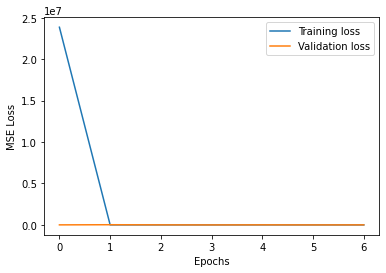

In [19]:
# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

Evaluate with test data

In [20]:
# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

Loading data into RAM


In [21]:
# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

TypeError: 'method' object is not subscriptable

In [ ]:
# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
#plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test, rmse,
torch.cuda.empty_cache()

## 2. All constants

In [ ]:
description = "all_const"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, orog, lats, lsm, slt, rad
in_features = 7
ds = xr.merge([z500, t850, orog, lats, lsm, slt, rad], compat='override')

train_mean_ = train_mean.copy()
train_std_ = train_std.copy()

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=20, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test, rmse,
torch.cuda.empty_cache()

# No orog

In [ ]:
description = "all_const_no_orog"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1, 3, 4, 5, 6]
in_features = len(feature_idx)
ds = xr.merge([z500, t850, lats, lsm, slt, rad], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

train_mean_ = train_mean[feature_idx]
train_std_ = train_std[feature_idx]

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=nb_epochs, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test, rmse,
torch.cuda.empty_cache()

# No lats

In [ ]:
description = "all_const_no_lats"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1, 2, 4, 5, 6]
in_features = len(feature_idx)
ds = xr.merge([z500, t850, orog, lsm, slt, rad], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

train_mean_ = train_mean[feature_idx]
train_std_ = train_std[feature_idx]

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=nb_epochs, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test, rmse,
torch.cuda.empty_cache()

# No lsm

In [ ]:
description = "all_const_no_lsm"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1, 2, 3, 5, 6]
in_features = len(feature_idx)
ds = xr.merge([z500, t850, orog, lats, slt, rad], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

train_mean_ = train_mean[feature_idx]
train_std_ = train_std[feature_idx]

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=nb_epochs, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test, rmse,
torch.cuda.empty_cache()

# No rad

In [ ]:
description = "all_const_no_rad"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1, 2, 3, 4, 5]
in_features = len(feature_idx)
ds = xr.merge([z500, t850, orog, lats, lsm, slt], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

train_mean_ = train_mean[feature_idx]
train_std_ = train_std[feature_idx]

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=nb_epochs, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test, rmse,
torch.cuda.empty_cache()

# No slt

In [ ]:
description = "all_const_no_slt"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1, 2, 3, 4, 6]
in_features = len(feature_idx)
ds = xr.merge([z500, t850, orog, lats, lsm, rad], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

train_mean_ = train_mean[feature_idx]
train_std_ = train_std[feature_idx]

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=nb_epochs, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test, rmse,
torch.cuda.empty_cache()

# All constants + longitude

In [ ]:
description = "all_const_lon"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# 'z500', 't850', 'orog', 'lat2d', 'lsm', 'slt', 'tisr', 'cos_lon', 'sin_lon'
in_features = 9
ds = xr.merge([z500, t850, orog, lats, lsm, slt, rad, cos_lon, sin_lon], compat='override')

train_mean_ = train_mean.copy()
train_std_ = train_std.copy()

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=30, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test, rmse,
torch.cuda.empty_cache()

# Comparison

In [ ]:
import matplotlib.pyplot as plt

metrics_path = '../data/healpix/metrics/'
rmse_noconst = xr.open_dataset(metrics_path + 'rmse_' + 'no_const' + '.nc')
rmse_all_const_no_orog = xr.open_dataset(metrics_path + 'rmse_' + 'all_const_no_orog' + '.nc')
rmse_all_const_no_lats = xr.open_dataset(metrics_path + 'rmse_' + 'all_const_no_lats' + '.nc')
rmse_all_const_no_lsm = xr.open_dataset(metrics_path + 'rmse_' + 'all_const_no_lsm' + '.nc')
rmse_all_const_no_slt = xr.open_dataset(metrics_path + 'rmse_' + 'all_const_no_slt' + '.nc')
rmse_all_const_no_rad = xr.open_dataset(metrics_path + 'rmse_' + 'all_const_no_rad' + '.nc')
rmse_all_const = xr.open_dataset(metrics_path + 'rmse_' + 'all_const' + '.nc')

lead_times = np.arange(6, max_lead_time + 6, 6)
xlabels = [str(t) if t%4 == 0 else '' for t in lead_times] if lead_times[0] < 12 else lead_times
labels = np.array(['No static\nfeatures', 'No orog', 'No lats', 'No land-\nsea', 'No rad', 'No soil\ntype', 
                   'All static\nfeatures'])
colors = np.array(['red', 'blue', 'limegreen', 'skyblue', 'yellow', 'orange', 'darkviolet'])

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))

ax1.plot(lead_times, rmse_noconst.z.values, label='No static features')
ax1.plot(lead_times, rmse_all_const_no_orog.z.values, label='No orography')
ax1.plot(lead_times, rmse_all_const_no_lats.z.values, label='No latitudes')
ax1.plot(lead_times, rmse_all_const_no_lsm.z.values, label='No land-sea mask')
ax1.plot(lead_times, rmse_all_const_no_slt.z.values, label='No soil type')
ax1.plot(lead_times, rmse_all_const_no_rad.z.values, label='No radiation')
ax1.plot(lead_times, rmse_all_const.z.values, label='All static features')

ax2.plot(lead_times, rmse_noconst.t.values, label='No static features')
ax2.plot(lead_times, rmse_all_const_no_orog.t.values, label='No orography')
ax2.plot(lead_times, rmse_all_const_no_lats.t.values, label='No latitudes')
ax2.plot(lead_times, rmse_all_const_no_lsm.t.values, label='No land-sea mask')
ax2.plot(lead_times, rmse_all_const_no_slt.t.values, label='No soil type')
ax2.plot(lead_times, rmse_all_const_no_rad.t.values, label='No radiation')
ax2.plot(lead_times, rmse_all_const.t.values, label='All static features')


ax1.set_xticks(lead_times)
ax2.set_xticks(lead_times)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax1.set_xticklabels(xlabels)
ax2.set_xticklabels(xlabels)
ax1.set_xlabel('Lead time [h]', fontsize='18')
ax2.set_xlabel('Lead time [h]', fontsize='18')
ax1.set_ylabel('RMSE [$m^2 s^{-2}$]', fontsize='18')
ax2.set_ylabel('RMSE [K]', fontsize='18')
ax1.set_title('Z500', fontsize='22')
ax2.set_title('T850', fontsize='22')
ax1.legend(fontsize=14)
ax2.legend(fontsize=14)

plt.tight_layout()

#plt.savefig('static_rmse_curves.eps', format='eps', bbox_inches='tight')

plt.show()

In [ ]:
rmse_noconst0 = rmse_noconst.isel(lead_time=0)
rmse_all_const_no_orog0 = rmse_all_const_no_orog.isel(lead_time=0)
rmse_all_const_no_lats0 = rmse_all_const_no_lats.isel(lead_time=0)
rmse_all_const_no_lsm0 = rmse_all_const_no_lsm.isel(lead_time=0)
rmse_all_const_no_slt0 = rmse_all_const_no_slt.isel(lead_time=0)
rmse_all_const_no_rad0 = rmse_all_const_no_rad.isel(lead_time=0)
rmse_all_const0 = rmse_all_const.isel(lead_time=0)

rmses_0 = [rmse_noconst0, rmse_all_const_no_orog0, rmse_all_const_no_lats0, rmse_all_const_no_lsm0, 
           rmse_all_const_no_rad0, rmse_all_const_no_slt0, rmse_all_const0]
rmses_z_0 = np.array([r.z.values for r in rmses_0])
rmses_t_0 = np.array([r.t.values for r in rmses_0])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))

f.suptitle('RMSE of first prediction, sorted in ascending order', fontsize=22, y=1.1)

N = len(labels)

ax1.bar(np.arange(N), rmses_z_0[np.argsort(rmses_z_0).tolist()], color=colors[np.argsort(rmses_z_0).tolist()])
ax1.set_xticks(np.arange(N))
ax1.set_ylim([75, 105])
ax1.set_xticklabels(labels[np.argsort(rmses_z_0).tolist()], fontsize=16)

ax2.bar(np.arange(N), rmses_t_0[np.argsort(rmses_t_0).tolist()], color=colors[np.argsort(rmses_t_0).tolist()])
ax2.set_xticks(np.arange(N))
ax2.set_ylim([0.72, 0.79])
ax2.set_xticklabels(labels[np.argsort(rmses_t_0).tolist()], fontsize=16)

ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)

ax1.set_ylabel('RMSE [$m^2 s^{-2}$]', fontsize='18')
ax2.set_ylabel('RMSE [K]', fontsize='18')
ax1.set_title('Z500', fontsize='22')
ax2.set_title('T850', fontsize='22')

plt.tight_layout()

#plt.savefig('static_rmse_first.eps', format='eps', bbox_inches='tight')

plt.show()

In [ ]:
rmse_noconst_last = rmse_noconst.isel(lead_time=-1)
rmse_all_const_no_orog_last = rmse_all_const_no_orog.isel(lead_time=-1)
rmse_all_const_no_lats_last = rmse_all_const_no_lats.isel(lead_time=-1)
rmse_all_const_no_lsm_last = rmse_all_const_no_lsm.isel(lead_time=-1)
rmse_all_const_no_slt_last = rmse_all_const_no_slt.isel(lead_time=-1)
rmse_all_const_no_rad_last = rmse_all_const_no_rad.isel(lead_time=-1)
rmse_all_const_last = rmse_all_const.isel(lead_time=-1)

rmses_last = [rmse_noconst_last, rmse_all_const_no_orog_last, rmse_all_const_no_lats_last, 
              rmse_all_const_no_lsm_last, rmse_all_const_no_rad_last, rmse_all_const_no_slt_last, 
              rmse_all_const_last]
rmses_z_last = np.array([r.z.values for r in rmses_last])
rmses_t_last = np.array([r.t.values for r in rmses_last])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))

f.suptitle('RMSE of last prediction, sorted in ascending order', fontsize=24, y=1.1)

N = len(labels)

ax1.bar(np.arange(N), rmses_z_last[np.argsort(rmses_z_last).tolist()], 
        color=colors[np.argsort(rmses_z_last).tolist()])
ax1.set_xticks(np.arange(N))
ax1.set_ylim([800, 1200])
ax1.set_xticklabels(labels[np.argsort(rmses_z_last).tolist()], fontsize='16')

ax2.bar(np.arange(N), rmses_t_last[np.argsort(rmses_t_last).tolist()], 
        color=colors[np.argsort(rmses_t_last).tolist()])
ax2.set_xticks(np.arange(N))
ax2.set_ylim([3, 6])
ax2.set_xticklabels(labels[np.argsort(rmses_t_last).tolist()], fontsize='16')

ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)

ax1.set_ylabel('RMSE [$m^2 s^{-2}$]', fontsize='18')
ax2.set_ylabel('RMSE [K]', fontsize='18')
ax1.set_title('Z500', fontsize='22')
ax2.set_title('T850', fontsize='22')

plt.tight_layout()

#plt.savefig('static_rmse_last.eps', format='eps', bbox_inches='tight')

plt.show()